In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler

In [2]:
df = pd.read_csv(r'/home/drumyr/Downloads/BankChurners.csv')

In [3]:
df = df.iloc[:,0:-2]
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


we will still need to do a tiny bit of data wrangling.The main part was dropping the,age'column.It is too highly colinear with the column which interests

In [4]:
list_str_obj_cols = df.columns[df.dtypes == "object"].tolist()
for str_obj_col in list_str_obj_cols:
    df[str_obj_col] = df[str_obj_col].astype("category")
df = df.drop(['Customer_Age','CLIENTNUM'],axis=1)

Z-test assumes normal distribution,so to do it we will find a column the most similar to normal distribution.To shorten the list we will use pairwise plot,as it shows not only relationships betweeen numerical columns,but also their distributions on their own.Here we can find all the kinds of relations,also seeing some clearly redundant features(due to visible multicolinearity).However,eliminating them is not our purpose,so we will ignore them.
Like that we were able to locate dependent feature,most resembling the normal distribution-Months on book

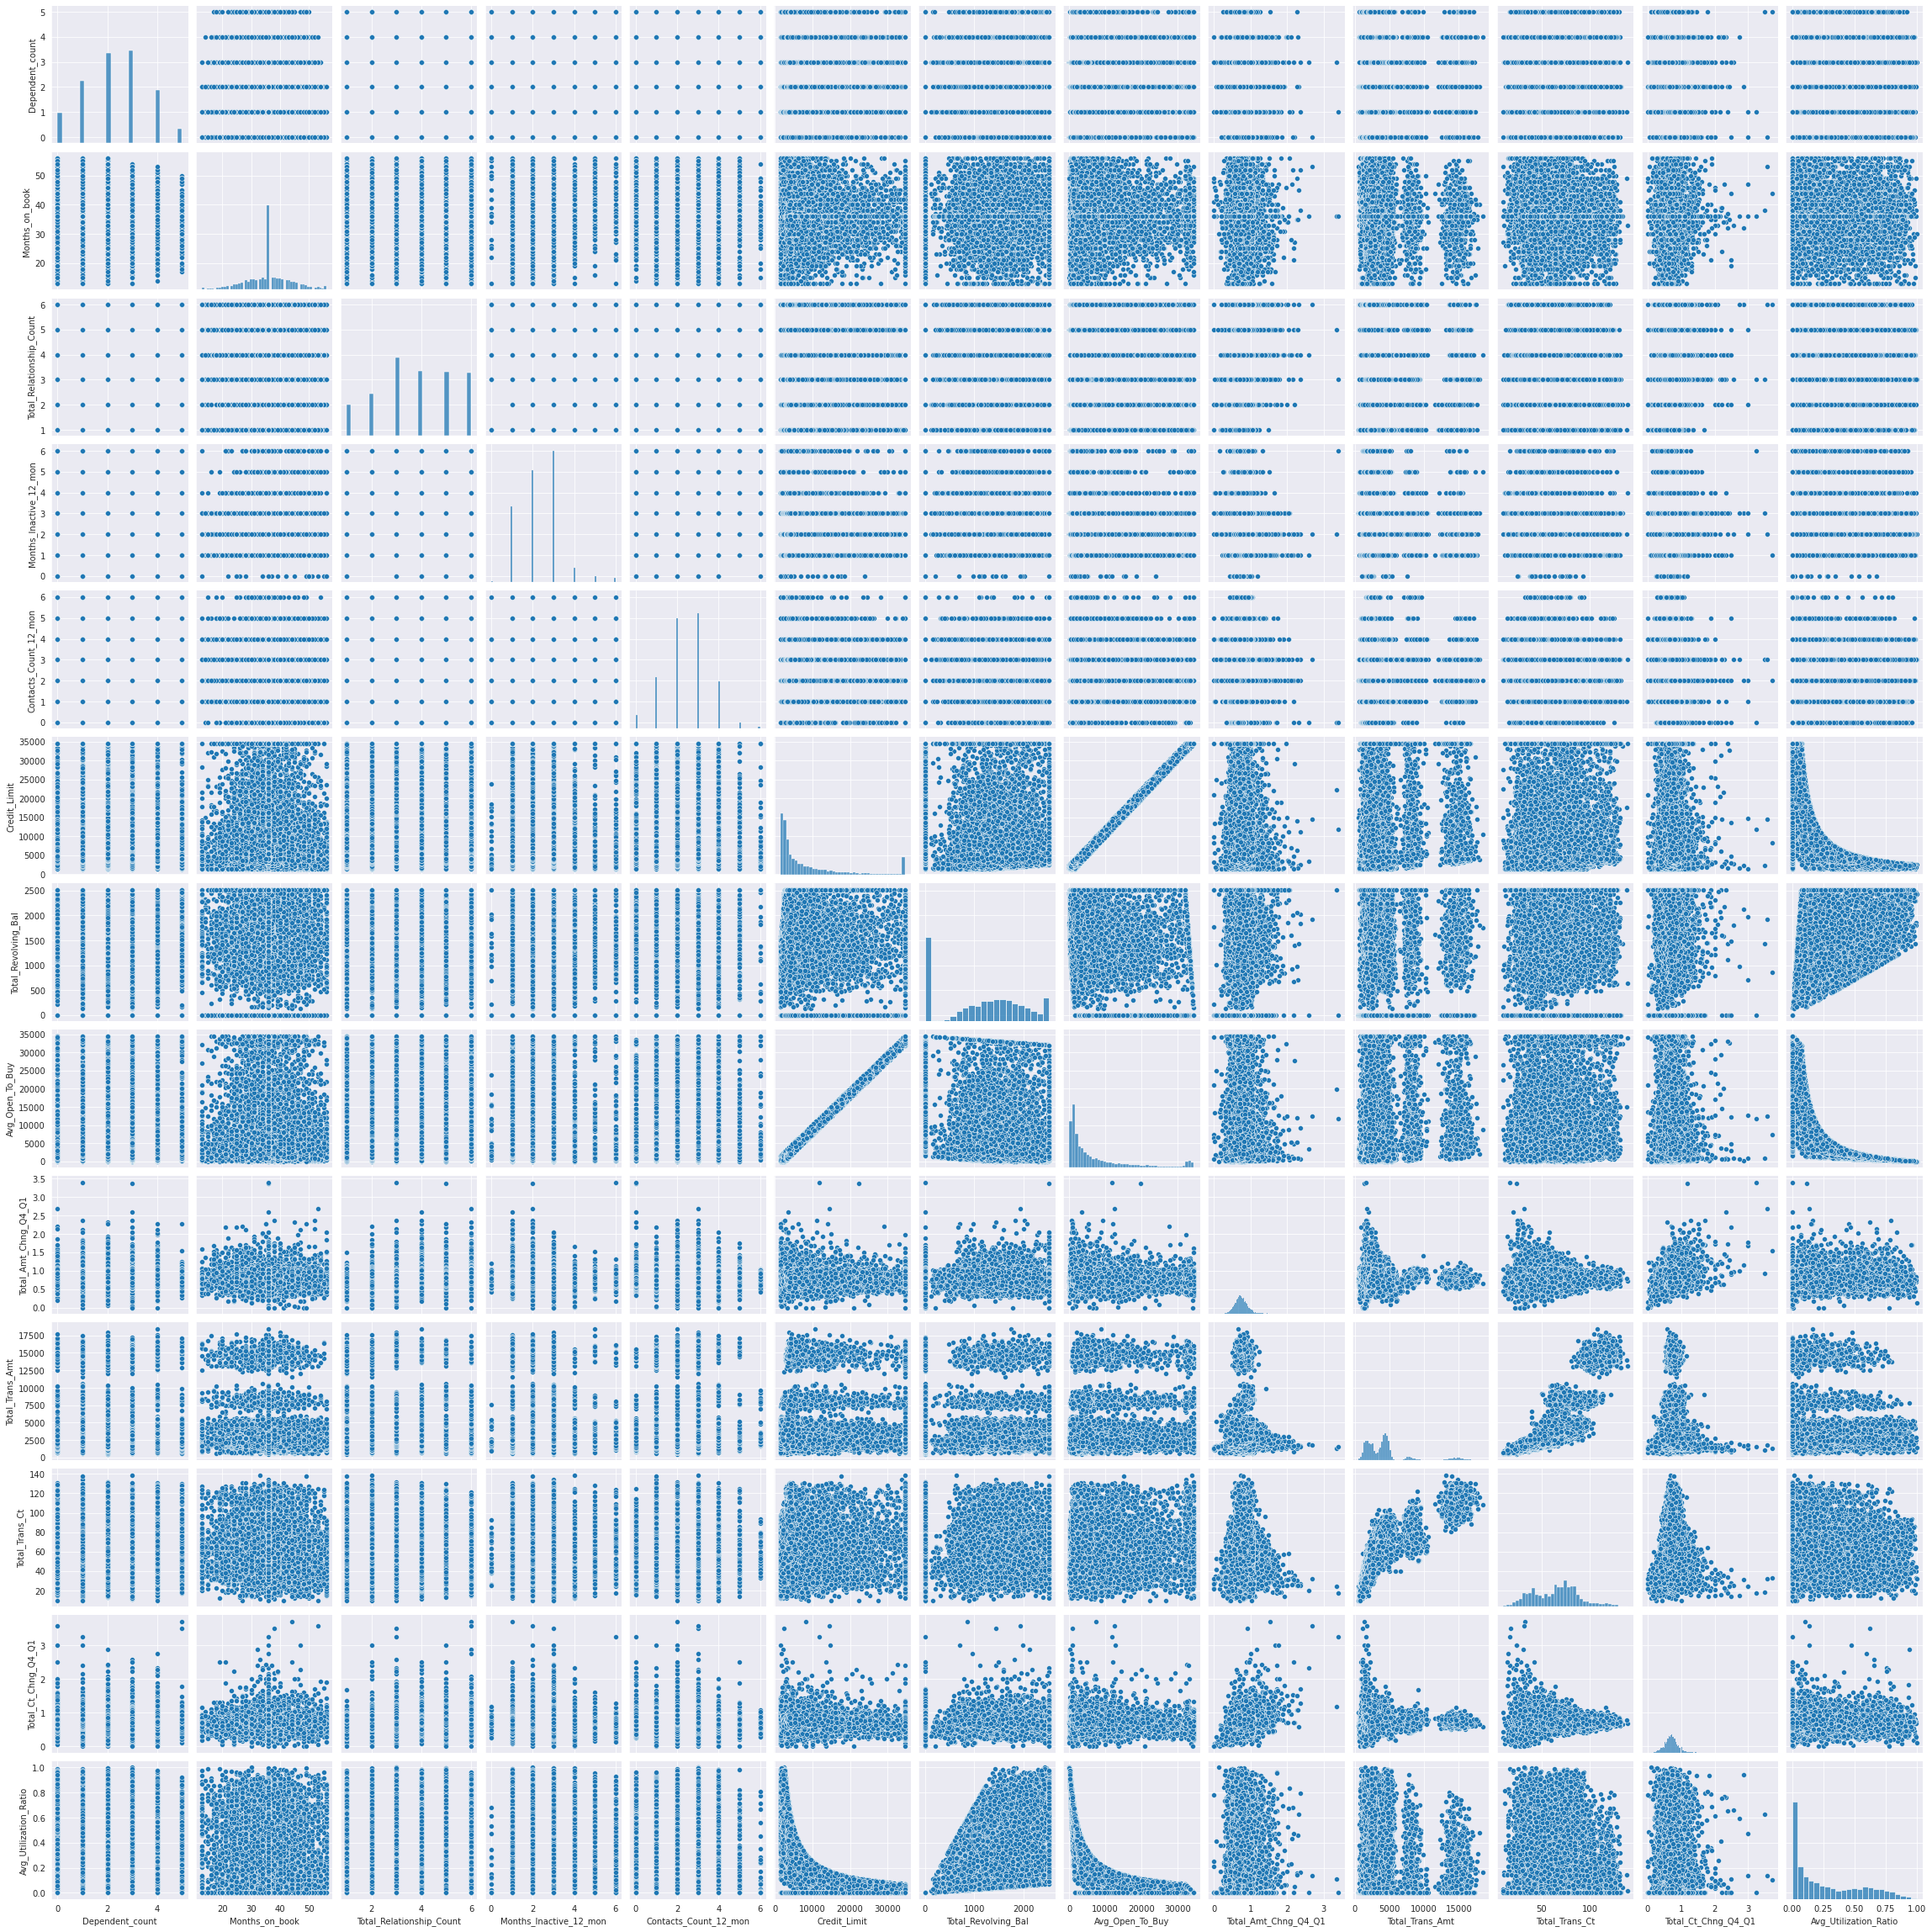

In [5]:
sns.pairplot(df)

now we check the column again to get a closer look.It is clearly not h=normal,being strongly-centered,but it is the best option we have(between dependent variables)Comparing the curtosis would work too,however main interest for Z-test is symmetry of distributionthus making it more suitable than other,heavily SKEWED options.It might not be a variable of interest,and would rather appear a variable,used FOR prediction or churn analysis,but it is not a matter of interest for our project.High positive kurtosis means that the tails ar heavier,and extreme values are more likely to appear,which can lead to more occurences of type 1 error.Thus,we will make significance treshold higher(lowering the max acceptable p-value)

<AxesSubplot:xlabel='Months_on_book', ylabel='Count'>

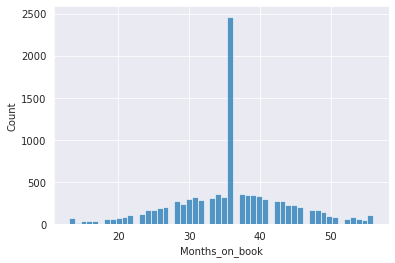

In [6]:
sns.histplot(df['Months_on_book'])

here we split dataset in two parts-categorical features(they are all independent,thus we do not exclude any)and the dependent column of interest

In [7]:
X_cat = df.select_dtypes('category')
total = df['Months_on_book']

one-hot encoding features(we could use ordinal encoding on features like age and education,but it would make feature selection way more complicated

In [8]:
X_encoded = pd.get_dummies(X_cat)
for col in X_encoded.columns:
    X_encoded[col] = X_encoded[col].astype('bool')

and we merge these new datasets on their indexes

In [9]:
df_for_testing = pd.merge(X_encoded,total, left_index=True, right_index=True).dropna()

Creating a scrip for performing z-test on each column,and eliminate(drop)those variables where p-value is greater then treshold(0.02)

In [10]:
def z_test(X,y):
        columns_to_drop = []
        for column in X.select_dtypes('bool').columns:
            #summary-z-test works by assuming the distribution is normal,and requires it's distribution basic parameters for each category(mean,standard deviation,and number of occurences for each value)
            mean1=X.loc[X[column]==True,y].mean()
            mean2=X.loc[X[column]==False,y].mean()
            sd1=X.loc[X[column]==True,y].std()
            sd2=X.loc[X[column]==False,y].std()
            n1=X.loc[X[column]==True,y].count()
            n2=X.loc[X[column]==False,y].count()
            pooledSE = np.sqrt((sd1**2/n1 + sd2**2/n2))
            z = (mean1 - mean2)/pooledSE
            #pvalue-states the chance that the null hypothesis is true and differences are actually caused by chance
            pval = 2*(1 - st.norm.cdf(abs(z)))
            if pval > 0.02:
                columns_to_drop.append(column)
            else:
                pass
        X = X.drop(columns_to_drop, axis=1)
        return X

In [11]:
df_for_testing = z_test(X=df_for_testing,y='Months_on_book')

In [12]:
df_for_testing.head()

,Education_Level_Doctorate,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Unknown,Income_Category_$120K +,Months_on_book
0,False,False,True,False,False,39
1,False,False,False,False,False,44
2,False,False,True,False,False,36
3,False,False,False,True,False,34
4,False,False,True,False,False,21


In [13]:
X_z_test = df_for_testing.drop('Months_on_book',axis=1)
y_z_test = df_for_testing['Months_on_book']

here,we wanted to check if there are any cases of extremely imbalanced sampling,that would create samples with numbers smaller than 30(making z-test unable to work at all).Turns out there aren't

In [14]:
freq_dict = {}
for col in X_z_test.columns:
    freq = X_z_test[col].value_counts()
    freq_dict[col] = freq
print(freq_dict)

{'Education_Level_Doctorate': False    9676
True      451
Name: Education_Level_Doctorate, dtype: int64, 'Marital_Status_Divorced': False    9379
True      748
Name: Marital_Status_Divorced, dtype: int64, 'Marital_Status_Married': False    5440
True     4687
Name: Marital_Status_Married, dtype: int64, 'Marital_Status_Unknown': False    9378
True      749
Name: Marital_Status_Unknown, dtype: int64, 'Income_Category_$120K +': False    9400
True      727
Name: Income_Category_$120K +, dtype: int64}


Here,we use two regression models on transformed data to get error rates.We have choseen these two models because they are both known to work as good on one-hot encoded variables,as on complex continuous variables,thus making it useful for comparison

In [21]:
knn = KNeighborsRegressor(n_neighbors=13)
X_train, X_test, y_train, y_test = train_test_split(X_z_test, y_z_test)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
mse_knn = mean_squared_error(y_test, y_pred_knn)
print("Mean Squared Error of KNNRegressor:", mse_knn)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred)
print("Mean Squared Error of RandomForestRegressor:", mse_rf)

Mean Squared Error of KNNRegressor: 64.23320199669087
Mean Squared Error of RandomForestRegressor: 63.550730569214636


Here,we do a little bit of data wrangling once again to eliminate dependent features).We are just trying to score if z-score is useful overall,not to compare it with other feature selection/extraction techniques)

In [16]:
X_as_it_was = df.drop('Months_on_book',axis=1)
y_for_comparing = df['Months_on_book']
X_as_it_was_cat = pd.get_dummies(X_as_it_was.select_dtypes('category'))
for col in X_as_it_was_cat.columns:
    X_as_it_was_cat[col] = X_as_it_was_cat[col].astype('bool')

robustscaler was chosen because most of the features are not normally distributed,thus making it more useful than min-max scaler or standard scaler

In [17]:
X_as_it_was = pd.merge(X_as_it_was_cat, X_as_it_was.drop(X_as_it_was.select_dtypes('category').columns,axis=1), left_index=True, right_index=True).drop(['Total_Trans_Amt','Avg_Utilization_Ratio','Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1','Credit_Limit'],axis=1).dropna()
scaler = RobustScaler()
X_as_it_was = scaler.fit_transform(X_as_it_was)

In [18]:
knn = KNeighborsRegressor(n_neighbors=13)
X_train, X_test, y_train, y_test = train_test_split(X_as_it_was, y_for_comparing)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
mse_knn = mean_squared_error(y_test, y_pred_knn)
print("Mean Squared Error of KNNRegressor:", mse_knn)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred)
print("Mean Squared Error of RandomForestRegressor:", mse_rf)

Mean Squared Error of KNNRegressor: 62.88598717481328
Mean Squared Error of RandomForestRegressor: 61.197166192733015


CONCLUSIONS
As a result of this study,we found out that feature selection using Z-test can DRASTICALLY reduce computational resources,getting quite similar results to working on the whole dataset.Obviously,by implementing other techniques for either feature extraction or selection,model could become much more precise.Also,data cleaning would be of a great help.However it is still not possible to decline great effectiveness of z-test in special cases(where it is a small project with huge amount of available data,and the distribution of value of interest is symmetrical(the closer it to normal the more it becomes useful